In [122]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns

# Settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")


In [2]:
# Load health/income file correctly
health = pd.read_csv(
    "HDPulse_data_export.csv",
    skiprows=4    # skip the 4 description lines at the top
)

print(health.head())
print(health.columns)


              County    FIPS Value (Dollars) Rank within US (of 3141 counties)
0      United States     0.0          78,538                               NaN
1        Connecticut  9000.0          93,760                           9 of 52
2     Windham County  9015.0          77,748                               586
3   New Haven County  9009.0          83,971                               383
4  New London County  9011.0          89,428                               261
Index(['County', 'FIPS', 'Value (Dollars)',
       'Rank within US (of 3141 counties)'],
      dtype='object')


In [5]:
# Load the core datasets
ev_reg = pd.read_csv("Electric_Vehicle_Registration_Data.csv")
charging = pd.read_csv("Electric_Vehicle_Charging_Stations.csv")
mv_reg = pd.read_csv("Motor_Vehicle_Registrations__2000_-_2023__MV-1_.csv")
health['Rank'] = health['Rank within US (of 3141 counties)'].str.extract('(\d+)').astype(float)
energy = pd.read_excel("2016cityandcountyenergyprofiles.xlsb", engine="pyxlsb")


<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
/var/folders/cv/lt0_qm2s5f11p3xt0drx0g4c0000gn/T/ipykernel_10709/2108526376.py:5: SyntaxWarning: invalid escape sequence '\d'
  health['Rank'] = health['Rank within US (of 3141 counties)'].str.extract('(\d+)').astype(float)


In [7]:
pip install pyxlsb


Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd

health_raw = pd.read_csv(
    "HDPulse_data_export.csv",
    skiprows=4,      # skip the 3 description lines + 1 blank line
    engine="python"  # more forgiving parser
)

print(health_raw.head())
print(health_raw.columns.tolist())


              County    FIPS Value (Dollars) Rank within US (of 3141 counties)
0      United States     0.0          78,538                               NaN
1        Connecticut  9000.0          93,760                           9 of 52
2     Windham County  9015.0          77,748                               586
3   New Haven County  9009.0          83,971                               383
4  New London County  9011.0          89,428                               261
['County', 'FIPS', 'Value (Dollars)', 'Rank within US (of 3141 counties)']


In [11]:
# Strip any leading/trailing spaces from column names
health_raw.columns = health_raw.columns.str.strip()

# Rename to simpler, lowercase names
health = health_raw.rename(columns={
    "County": "county",
    "FIPS": "fips",
    "Value (Dollars)": "median_income",
    "Rank within US (of 3141 counties)": "us_rank"
})


In [13]:
health = health[health["county"] != "United States"].copy()


In [15]:
print(health["median_income"].head(10))


1      93,760
2      77,748
3      83,971
4      89,428
5      89,982
6      95,323
7      97,859
8     103,443
9     114,462
10       None
Name: median_income, dtype: object


In [17]:
# Clean income safely
health["median_income"] = (
    health["median_income"]
    .astype(str)
    .str.replace(",", "", regex=False)   # remove commas
)

health["median_income"] = pd.to_numeric(
    health["median_income"],
    errors="coerce"   # convert invalid strings to NaN
)


In [19]:
health = health.dropna(subset=["median_income"]).copy()
health["median_income"] = health["median_income"].astype(int)


In [21]:
health["us_rank"] = (
    health["us_rank"]
    .astype(str)
    .str.extract(r"(\d+)", expand=False)   # extract only the number
)

health["us_rank"] = pd.to_numeric(
    health["us_rank"],
    errors="coerce"
)

health = health.dropna(subset=["us_rank"]).copy()
health["us_rank"] = health["us_rank"].astype(int)


In [23]:
# Clean income: remove commas and convert to int
health["median_income"] = (
    health["median_income"]
      .astype(str)
      .str.replace(",", "", regex=False)
      .astype(int)
)

# Clean rank: grab the first number in the string
health["us_rank"] = (
    health["us_rank"]
      .astype(str)
      .str.extract(r"(\d+)", expand=False)   # '9 of 52' -> '9'
      .astype(int)
)

print(health)
print(health.dtypes)


              county    fips  median_income  us_rank
1        Connecticut  9000.0          93760        9
2     Windham County  9015.0          77748      586
3   New Haven County  9009.0          83971      383
4  New London County  9011.0          89428      261
5    Hartford County  9003.0          89982      253
6  Litchfield County  9005.0          95323      191
7   Middlesex County  9007.0          97859      166
8     Tolland County  9013.0         103443      118
9   Fairfield County  9001.0         114462       59
county            object
fips             float64
median_income      int64
us_rank            int64
dtype: object


In [25]:
ev = pd.read_csv("Electric_Vehicle_Registration_Data.csv", low_memory=False)
print(ev.head())
print(ev.columns)


    ID Plate Type Primary Customer City Primary Customer State  \
0   13  Passenger           GLASTONBURY                     CT   
1   19  Passenger                ORANGE                     CT   
2   21  Passenger            LITCHFIELD                     CT   
3   73  Passenger               NORWALK                     CT   
4  126  Passenger           SOUTHINGTON                     CT   

  Registration Start Date Registration Expiration Date Registration Usage  \
0              02/17/2023                   02/16/2026            Regular   
1              02/23/2023                   02/22/2026            Regular   
2              02/23/2023                   02/22/2026            Regular   
3              02/20/2023                   02/19/2026            Regular   
4              02/18/2023                   02/17/2026            Regular   

  Vehicle Type  Vehicle Weight  Vehicle Year Vehicle Make  \
0          SUV               0          2023        Tesla   
1          SUV    

In [27]:
print(ev.shape)
print(ev.columns)
ev.head(3)


(60489, 20)
Index(['ID', 'Plate Type', 'Primary Customer City', 'Primary Customer State',
       'Registration Start Date', 'Registration Expiration Date',
       'Registration Usage', 'Vehicle Type', 'Vehicle Weight', 'Vehicle Year',
       'Vehicle Make', 'Vehicle Model', 'Vehicle Body', 'Primary Color',
       'Vehicle Declared Gross Weight', 'Fuel Code', 'Vehicle Recorded GVWR',
       'Vehicle Name', 'Type', 'Vehicle Category'],
      dtype='object')


,ID,Plate Type,Primary Customer City,Primary Customer State,Registration Start Date,Registration Expiration Date,Registration Usage,Vehicle Type,Vehicle Weight,Vehicle Year,Vehicle Make,Vehicle Model,Vehicle Body,Primary Color,Vehicle Declared Gross Weight,Fuel Code,Vehicle Recorded GVWR,Vehicle Name,Type,Vehicle Category
0,13,Passenger,GLASTONBURY,CT,02/17/2023,02/16/2026,Regular,SUV,0,2023,Tesla,Model Y,SU,Black,0,E00,0,Tesla Model Y,BEV,Light-Duty (Class 1-2)
1,19,Passenger,ORANGE,CT,02/23/2023,02/22/2026,Regular,SUV,0,2023,Jeep,Wrangler Sahara 4xe,4W,White,0,H04,0,Jeep Wrangler Plug In,PHEV,Light-Duty (Class 1-2)
2,21,Passenger,LITCHFIELD,CT,02/23/2023,02/22/2026,Regular,SUV,0,2023,Tesla,Model Y,SU,Gray,0,E00,0,Tesla Model Y,BEV,Light-Duty (Class 1-2)


In [29]:
# Make a working copy
ev_clean = ev.copy()

# Standardize column names (lowercase and underscores)
ev_clean.columns = ev_clean.columns.str.lower().str.replace(" ", "_")

print(ev_clean.columns)
ev_clean.head(3)


Index(['id', 'plate_type', 'primary_customer_city', 'primary_customer_state',
       'registration_start_date', 'registration_expiration_date',
       'registration_usage', 'vehicle_type', 'vehicle_weight', 'vehicle_year',
       'vehicle_make', 'vehicle_model', 'vehicle_body', 'primary_color',
       'vehicle_declared_gross_weight', 'fuel_code', 'vehicle_recorded_gvwr',
       'vehicle_name', 'type', 'vehicle_category'],
      dtype='object')


,id,plate_type,primary_customer_city,primary_customer_state,registration_start_date,registration_expiration_date,registration_usage,vehicle_type,vehicle_weight,vehicle_year,vehicle_make,vehicle_model,vehicle_body,primary_color,vehicle_declared_gross_weight,fuel_code,vehicle_recorded_gvwr,vehicle_name,type,vehicle_category
0,13,Passenger,GLASTONBURY,CT,02/17/2023,02/16/2026,Regular,SUV,0,2023,Tesla,Model Y,SU,Black,0,E00,0,Tesla Model Y,BEV,Light-Duty (Class 1-2)
1,19,Passenger,ORANGE,CT,02/23/2023,02/22/2026,Regular,SUV,0,2023,Jeep,Wrangler Sahara 4xe,4W,White,0,H04,0,Jeep Wrangler Plug In,PHEV,Light-Duty (Class 1-2)
2,21,Passenger,LITCHFIELD,CT,02/23/2023,02/22/2026,Regular,SUV,0,2023,Tesla,Model Y,SU,Gray,0,E00,0,Tesla Model Y,BEV,Light-Duty (Class 1-2)


In [31]:
# Convert date columns to datetime
ev_clean['registration_start_date'] = pd.to_datetime(ev_clean['registration_start_date'], errors='coerce')
ev_clean['registration_expiration_date'] = pd.to_datetime(ev_clean['registration_expiration_date'], errors='coerce')

# Vehicle year as numeric
ev_clean['vehicle_year'] = pd.to_numeric(ev_clean['vehicle_year'], errors='coerce')


In [33]:
# Remove leading/trailing spaces and convert to title case
ev_clean['primary_customer_city'] = (
    ev_clean['primary_customer_city']
    .str.strip()
    .str.title()
)


In [35]:
ev_clean['vehicle_make'] = ev_clean['vehicle_make'].str.title()
ev_clean['vehicle_model'] = ev_clean['vehicle_model'].str.title()
ev_clean['vehicle_type'] = ev_clean['vehicle_type'].str.upper()


In [37]:
ev_clean = ev_clean[ev_clean['primary_customer_state'] == 'CT']   # keep only Connecticut
ev_clean = ev_clean.drop_duplicates(subset=['id'])                 # remove duplicates


In [39]:
# EV Count per row = 1 (each row is one registered vehicle)
ev_clean['ev_count'] = 1

# Broad category: BEV / PHEV / UNKNOWN
ev_clean['ev_category'] = ev_clean['fuel_code'].replace({
    'E00': 'BEV',
    'H04': 'PHEV'
}).fillna('Other')


In [41]:
print(ev_clean.head())
print(ev_clean.dtypes)
print(ev_clean.shape)


    id plate_type primary_customer_city primary_customer_state  \
0   13  Passenger           Glastonbury                     CT   
1   19  Passenger                Orange                     CT   
2   21  Passenger            Litchfield                     CT   
3   73  Passenger               Norwalk                     CT   
4  126  Passenger           Southington                     CT   

  registration_start_date registration_expiration_date registration_usage  \
0              2023-02-17                   2026-02-16            Regular   
1              2023-02-23                   2026-02-22            Regular   
2              2023-02-23                   2026-02-22            Regular   
3              2023-02-20                   2026-02-19            Regular   
4              2023-02-18                   2026-02-17            Regular   

  vehicle_type  vehicle_weight  vehicle_year vehicle_make  \
0          SUV               0          2023        Tesla   
1          SUV    

In [43]:
ch = charging.copy()
ch.columns = (
    ch.columns.str.lower()
    .str.replace(" ", "_")
    .str.replace(r"[^a-z0-9_]", "", regex=True)
)
print(ch.columns)


Index(['station_name', 'street_address', 'city', 'access_days_time',
       'ev_level1_evse_num', 'ev_level2_evse_num', 'ev_dc_fast_count',
       'ev_other_info', 'new_georeferenced_column'],
      dtype='object')


In [45]:
print(ch.columns.tolist())


['station_name', 'street_address', 'city', 'access_days_time', 'ev_level1_evse_num', 'ev_level2_evse_num', 'ev_dc_fast_count', 'ev_other_info', 'new_georeferenced_column']


In [47]:
ch['city'] = (
    ch['city'].astype(str)
    .str.strip()
    .str.title()
)


In [111]:
[c for c in ch.columns if "connector" in c.lower()]


['is_tesla_connector', 'has_other_connector_info']

In [113]:
conn_col = [c for c in ch.columns if "connector" in c.lower()][0]
print("Using connector column:", conn_col)

ch[conn_col] = ch[conn_col].fillna("").str.upper()

ch['has_j1772']   = ch[conn_col].str.contains("J1772", regex=False).astype(int)
ch['has_ccs']     = ch[conn_col].str.contains("COMBO|CCS", regex=True).astype(int)
ch['has_chademo'] = ch[conn_col].str.contains("CHADEMO", regex=False).astype(int)
ch['has_tesla']   = ch[conn_col].str.contains("TESLA", regex=False).astype(int)


Using connector column: is_tesla_connector


AttributeError: Can only use .str accessor with string values!

In [53]:
# Convert charger counts to numeric
for col in ['ev_level1_evse_num', 'ev_level2_evse_num', 'ev_dc_fast_count']:
    ch[col] = pd.to_numeric(ch[col], errors='coerce').fillna(0).astype(int)

# Create useful derived metrics
ch['total_chargers'] = (
    ch['ev_level1_evse_num'] +
    ch['ev_level2_evse_num'] +
    ch['ev_dc_fast_count']
)

ch['has_dc_fast'] = (ch['ev_dc_fast_count'] > 0).astype(int)
ch['has_level2'] = (ch['ev_level2_evse_num'] > 0).astype(int)
ch['has_level1'] = (ch['ev_level1_evse_num'] > 0).astype(int)

print(ch.head())


                          station_name          street_address          city  \
0                        BMW OF DARIEN        138-142 Ledge Rd        Darien   
1         Dunkin’ - Tesla Supercharger           893 E Main St       Meriden   
2  Town of Beacon Falls - Commuter Lot           105 N Main St  Beacon Falls   
3                      OLD SAYBROOK VW  319 Middlesex Turnpike  Old Saybrook   
4               Fairfield Rail Station        80 Mill Plain Rd     Fairfield   

                     access_days_time  ev_level1_evse_num  ev_level2_evse_num  \
0                      24 hours daily                   0                   2   
1  24 hours daily; for Tesla use only                   0                   0   
2                      24 hours daily                   0                   1   
3                      24 hours daily                   0                   2   
4                      24 hours daily                   0                   2   

   ev_dc_fast_count ev_other_inf

In [55]:
ch['ev_other_info'].unique()[:20]


array(['NONE', '1 Conductive 120V', '1 Tesla Conductive'], dtype=object)

In [57]:
# Normalize text
ch['ev_other_info'] = ch['ev_other_info'].fillna("").str.upper().str.strip()

# Create connector flags based on available info
ch['is_tesla_connector'] = ch['ev_other_info'].str.contains("TESLA").astype(int)
ch['is_conductive_120'] = ch['ev_other_info'].str.contains("120V").astype(int)
ch['has_other_connector_info'] = (ch['ev_other_info'] != "NONE").astype(int)

print(ch[['ev_other_info', 'is_tesla_connector', 'is_conductive_120', 'has_other_connector_info']].head())


  ev_other_info  is_tesla_connector  is_conductive_120  \
0          NONE                   0                  0   
1          NONE                   0                  0   
2          NONE                   0                  0   
3          NONE                   0                  0   
4          NONE                   0                  0   

   has_other_connector_info  
0                         0  
1                         0  
2                         0  
3                         0  
4                         0  


In [59]:
print(ev_reg.columns.tolist())
ev_reg.head(3)


['ID', 'Plate Type', 'Primary Customer City', 'Primary Customer State', 'Registration Start Date', 'Registration Expiration Date', 'Registration Usage', 'Vehicle Type', 'Vehicle Weight', 'Vehicle Year', 'Vehicle Make', 'Vehicle Model', 'Vehicle Body', 'Primary Color', 'Vehicle Declared Gross Weight', 'Fuel Code', 'Vehicle Recorded GVWR', 'Vehicle Name', 'Type', 'Vehicle Category']


,ID,Plate Type,Primary Customer City,Primary Customer State,Registration Start Date,Registration Expiration Date,Registration Usage,Vehicle Type,Vehicle Weight,Vehicle Year,Vehicle Make,Vehicle Model,Vehicle Body,Primary Color,Vehicle Declared Gross Weight,Fuel Code,Vehicle Recorded GVWR,Vehicle Name,Type,Vehicle Category
0,13,Passenger,GLASTONBURY,CT,02/17/2023,02/16/2026,Regular,SUV,0,2023,Tesla,Model Y,SU,Black,0,E00,0,Tesla Model Y,BEV,Light-Duty (Class 1-2)
1,19,Passenger,ORANGE,CT,02/23/2023,02/22/2026,Regular,SUV,0,2023,Jeep,Wrangler Sahara 4xe,4W,White,0,H04,0,Jeep Wrangler Plug In,PHEV,Light-Duty (Class 1-2)
2,21,Passenger,LITCHFIELD,CT,02/23/2023,02/22/2026,Regular,SUV,0,2023,Tesla,Model Y,SU,Gray,0,E00,0,Tesla Model Y,BEV,Light-Duty (Class 1-2)


In [61]:
print(ch.columns.tolist())
ch.head(3)


['station_name', 'street_address', 'city', 'access_days_time', 'ev_level1_evse_num', 'ev_level2_evse_num', 'ev_dc_fast_count', 'ev_other_info', 'new_georeferenced_column', 'total_chargers', 'has_dc_fast', 'has_level2', 'has_level1', 'is_tesla_connector', 'is_conductive_120', 'has_other_connector_info']


,station_name,street_address,city,access_days_time,ev_level1_evse_num,ev_level2_evse_num,ev_dc_fast_count,ev_other_info,new_georeferenced_column,total_chargers,has_dc_fast,has_level2,has_level1,is_tesla_connector,is_conductive_120,has_other_connector_info
0,BMW OF DARIEN,138-142 Ledge Rd,Darien,24 hours daily,0,2,0,NONE,POINT (-73.4764687 41.072882),2,0,1,0,0,0,0
1,Dunkin’ - Tesla Supercharger,893 E Main St,Meriden,24 hours daily; for Tesla use only,0,0,8,NONE,POINT (-72.773473 41.527367),8,1,0,0,0,0,0
2,Town of Beacon Falls - Commuter Lot,105 N Main St,Beacon Falls,24 hours daily,0,1,0,NONE,POINT (-73.065583 41.44548100000001),1,0,1,0,0,0,0


In [63]:
print(health.columns.tolist())
health.head(3)


['county', 'fips', 'median_income', 'us_rank']


,county,fips,median_income,us_rank
1,Connecticut,9000.0,93760,9
2,Windham County,9015.0,77748,586
3,New Haven County,9009.0,83971,383


In [65]:
print(energy.columns.tolist())
energy.head(3)


['City and County Energy Profiles', 'Unnamed: 1', 'Unnamed: 2']


,City and County Energy Profiles,Unnamed: 1,Unnamed: 2
0,Dataset Completed: 12/3/2019,NaN,NaN
1,NaN,NaN,NaN
2,This City and County Energy Profiles data look...,NaN,NaN


In [67]:
print(ev_reg['Primary Customer City'].unique()[:20])
print(ch['city'].unique()[:20])


['GLASTONBURY' 'ORANGE' 'LITCHFIELD' 'NORWALK' 'SOUTHINGTON' 'MANCHESTER'
 'GUILFORD' 'BROOKFIELD' 'RIDGEFIELD' 'WEST HARTFORD' 'DARIEN'
 'NEW CANAAN' 'NORTHFORD' 'LYME' 'FARMINGTON' 'TRUMBULL' 'DANIELSON'
 'WESTPORT' 'HAMDEN' 'SHELTON']
['Darien' 'Meriden' 'Beacon Falls' 'Old Saybrook' 'Fairfield' 'Norwich'
 'West Hartford' 'Glastonbury' 'Groton' 'Waterbury' 'Farmington' 'Shelton'
 'Wallingford' 'Rocky Hill' 'New Haven' 'Easton' 'Manchester' 'Colebrook'
 'Mystic' 'Windsor Locks']


##Clean city names & create a CT city → county mapping table

In [70]:
def clean_city(col):
    return (col.str.strip()
               .str.upper()
               .str.replace(r"[^A-Z\s]", "", regex=True)   # remove punctuation
               .str.replace(r"\s+", " ", regex=True))      # fix double spaces

ev_reg["city_clean"] = clean_city(ev_reg["Primary Customer City"])
ch["city_clean"]     = clean_city(ch["city"])


In [72]:
ev_cities = set(ev_reg["city_clean"].dropna().astype(str))
ch_cities = set(ch["city_clean"].dropna().astype(str))

# remove 'nan', empty strings, etc.
ev_cities = {c for c in ev_cities if c not in ["", "NAN", "NONE", "NULL"]}
ch_cities = {c for c in ch_cities if c not in ["", "NAN", "NONE", "NULL"]}

all_cities = sorted(ev_cities.union(ch_cities))
print(len(all_cities))
print(all_cities[:30])


402
['ALPHARETTA', 'AMSTON', 'ANDOVER', 'ANSONIA', 'ARLINGTON', 'ARMONK', 'ASHFORD', 'ASHLAND', 'ATLANTA', 'AUSTIN', 'AVON', 'BALLOUVILLE', 'BALTIC', 'BANTAM', 'BARKHAMSTED', 'BASKING RIDGE', 'BATAVIA', 'BEACON FALLS', 'BEDFORD HILLS', 'BERLIN', 'BETHANY', 'BETHEL', 'BETHESDA', 'BETHLEHEM', 'BLOOMFIELD', 'BOCA RATON', 'BOLTON', 'BOSTON', 'BOZRAH', 'BRANFORD']


In [74]:
print(len(all_cities))
print(all_cities)


402
['ALPHARETTA', 'AMSTON', 'ANDOVER', 'ANSONIA', 'ARLINGTON', 'ARMONK', 'ASHFORD', 'ASHLAND', 'ATLANTA', 'AUSTIN', 'AVON', 'BALLOUVILLE', 'BALTIC', 'BANTAM', 'BARKHAMSTED', 'BASKING RIDGE', 'BATAVIA', 'BEACON FALLS', 'BEDFORD HILLS', 'BERLIN', 'BETHANY', 'BETHEL', 'BETHESDA', 'BETHLEHEM', 'BLOOMFIELD', 'BOCA RATON', 'BOLTON', 'BOSTON', 'BOZRAH', 'BRANFORD', 'BRIDGEPORT', 'BRIDGETON', 'BRIDGEWATER', 'BRISTOL', 'BROAD BROOK', 'BRONX', 'BROOKFIELD', 'BROOKLYN', 'BUFFALO GROVE', 'BURLIGAME', 'BURLINGTON', 'CAMBRIDGE', 'CANAAN', 'CANTERBURY', 'CANTON', 'CANTON CENTER', 'CARY', 'CENTENNIAL', 'CENTERBROOK', 'CENTRAL VILLAGE', 'CHAPLIN', 'CHARLOTTE', 'CHATSWORTH', 'CHESHIRE', 'CHESTER', 'CLINTON', 'COBALT', 'COLCHESTER', 'COLEBROOK', 'COLLEGE STATION', 'COLLINSVILLE', 'COLUMBIA', 'COLUMBUS', 'CORNWALL', 'CORNWALL BRIDGE', 'CORONA', 'COS COB', 'COVENTRY', 'CROMWELL', 'CUPERTINO', 'DALLAS', 'DANBURY', 'DANIELSON', 'DARIEN', 'DAVIDSON', 'DAYVILLE', 'DEARBORN', 'DEEP RIVER', 'DERBY', 'DES PLAINE

In [76]:
ct_towns = [
    'Andover','Ansonia','Ashford','Avon','Barkhamsted','Berlin','Bethany','Bethel',
    'Bethlehem','Bloomfield','Bolton','Bozrah','Branford','Bridgeport','Bridgewater',
    'Bristol','Brookfield','Brooklyn','Burlington','Canaan','Canterbury','Canton',
    'Chaplin','Cheshire','Chester','Clinton','Colchester','Colebrook','Columbia',
    'Cornwall','Coventry','Cromwell','Danbury','Darien','Deep River','Derby',
    'Durham','East Granby','East Haddam','East Hampton','East Hartford','East Haven',
    'East Lyme','East Windsor','Eastford','Easton','Ellington','Enfield','Essex',
    'Fairfield','Farmington','Franklin','Glastonbury','Goshen','Granby','Greenwich',
    'Griswold','Groton','Guilford','Haddam','Hamden','Hampton','Hartford','Hartland',
    'Harwinton','Hebron','Kent','Killingly','Killingworth','Lebanon','Ledyard',
    'Lisbon','Litchfield','Lyme','Madison','Manchester','Mansfield','Marlborough',
    'Meriden','Middlebury','Middletown','Milford','Monroe','Montville','Morris',
    'Naugatuck','New Britain','New Canaan','New Fairfield','New Hartford','New Haven',
    'New London','New Milford','Newington','Newtown','Norfolk','North Branford',
    'North Canaan','North Haven','North Stonington','Norwalk','Norwich','Old Lyme',
    'Old Saybrook','Orange','Oxford','Plainfield','Plainville','Plymouth','Pomfret',
    'Portland','Preston','Prospect','Putnam','Redding','Ridgefield','Rocky Hill',
    'Roxbury','Salem','Salisbury','Scotland','Seymour','Sharon','Shelton',
    'Sherman','Simsbury','Somers','South Windsor','Southbury','Southington',
    'Sprague','Stafford','Stamford','Sterling','Stonington','Stratford','Suffield',
    'Thomaston','Thompson','Tolland','Torrington','Trumbull','Union','Vernon',
    'Voluntown','Wallingford','Warren','Washington','Waterbury','Waterford',
    'Watertown','West Hartford','West Haven','Westbrook','Weston','Westport',
    'Wethersfield','Willington','Wilton','Winchester','Windham','Windsor',
    'Windsor Locks','Wolcott','Woodbridge','Woodbury','Woodstock'
]


In [78]:
def normalize_city(c):
    if pd.isna(c):
        return None
    return str(c).strip().upper()

# Normalize
all_cities_norm = [normalize_city(c) for c in all_cities]

# Normalize CT towns as well
ct_towns_norm = [t.upper() for t in ct_towns]

# Keep only CT towns
ct_cities_present = sorted(set([c for c in all_cities_norm if c in ct_towns_norm]))

print(len(ct_cities_present))
print(ct_cities_present)


164
['ANDOVER', 'ANSONIA', 'ASHFORD', 'AVON', 'BARKHAMSTED', 'BERLIN', 'BETHANY', 'BETHEL', 'BETHLEHEM', 'BLOOMFIELD', 'BOLTON', 'BOZRAH', 'BRANFORD', 'BRIDGEPORT', 'BRIDGEWATER', 'BRISTOL', 'BROOKFIELD', 'BROOKLYN', 'BURLINGTON', 'CANAAN', 'CANTERBURY', 'CANTON', 'CHAPLIN', 'CHESHIRE', 'CHESTER', 'CLINTON', 'COLCHESTER', 'COLEBROOK', 'COLUMBIA', 'CORNWALL', 'COVENTRY', 'CROMWELL', 'DANBURY', 'DARIEN', 'DEEP RIVER', 'DERBY', 'DURHAM', 'EAST GRANBY', 'EAST HADDAM', 'EAST HAMPTON', 'EAST HARTFORD', 'EAST HAVEN', 'EAST LYME', 'EAST WINDSOR', 'EASTFORD', 'EASTON', 'ELLINGTON', 'ENFIELD', 'ESSEX', 'FAIRFIELD', 'FARMINGTON', 'GLASTONBURY', 'GOSHEN', 'GRANBY', 'GREENWICH', 'GRISWOLD', 'GROTON', 'GUILFORD', 'HADDAM', 'HAMDEN', 'HAMPTON', 'HARTFORD', 'HARWINTON', 'HEBRON', 'KENT', 'KILLINGLY', 'KILLINGWORTH', 'LEBANON', 'LEDYARD', 'LISBON', 'LITCHFIELD', 'LYME', 'MADISON', 'MANCHESTER', 'MANSFIELD', 'MARLBOROUGH', 'MERIDEN', 'MIDDLEBURY', 'MIDDLETOWN', 'MILFORD', 'MONROE', 'MONTVILLE', 'MORRIS'

In [80]:
ct_city_to_county = {
    # Fairfield County
    'BETHEL': 'Fairfield', 'BRIDGEPORT': 'Fairfield', 'BROOKFIELD': 'Fairfield',
    'DANBURY': 'Fairfield', 'DARIEN': 'Fairfield', 'EASTON': 'Fairfield',
    'FAIRFIELD': 'Fairfield', 'GREENWICH': 'Fairfield', 'MONROE': 'Fairfield',
    'NEW CANAAN': 'Fairfield', 'NEW FAIRFIELD': 'Fairfield', 'NEWTOWN': 'Fairfield',
    'NORWALK': 'Fairfield', 'REDDING': 'Fairfield', 'RIDGEFIELD': 'Fairfield',
    'SHELTON': 'Fairfield', 'SHERMAN': 'Fairfield', 'STAMFORD': 'Fairfield',
    'STRATFORD': 'Fairfield', 'TRUMBULL': 'Fairfield', 'WESTON': 'Fairfield',
    'WESTPORT': 'Fairfield', 'WILTON': 'Fairfield',

    # Hartford County
    'AVON': 'Hartford', 'BERLIN': 'Hartford', 'BLOOMFIELD': 'Hartford',
    'BRISTOL': 'Hartford', 'BURLINGTON': 'Hartford', 'CANTON': 'Hartford',
    'EAST GRANBY': 'Hartford', 'EAST HARTFORD': 'Hartford', 'EAST WINDSOR': 'Hartford',
    'ENFIELD': 'Hartford', 'FARMINGTON': 'Hartford', 'GLASTONBURY': 'Hartford',
    'GRANBY': 'Hartford', 'HARTFORD': 'Hartford', 'MANCHESTER': 'Hartford',
    'MARLBOROUGH': 'Hartford', 'NEW BRITAIN': 'Hartford', 'NEWINGTON': 'Hartford',
    'PLAINVILLE': 'Hartford', 'ROCKY HILL': 'Hartford', 'SIMSBURY': 'Hartford',
    'SOUTH WINDSOR': 'Hartford', 'SUFFIELD': 'Hartford', 'WEST HARTFORD': 'Hartford',
    'WETHERSFIELD': 'Hartford', 'WINDSOR': 'Hartford', 'WINDSOR LOCKS': 'Hartford',

    # Litchfield County
    'BARKHAMSTED': 'Litchfield', 'BETHLEHEM': 'Litchfield', 'BRIDGEWATER': 'Litchfield',
    'CANAAN': 'Litchfield', 'COLEBROOK': 'Litchfield', 'CORNWALL': 'Litchfield',
    'GOSHEN': 'Litchfield', 'HARWINTON': 'Litchfield', 'KENT': 'Litchfield',
    'LITCHFIELD': 'Litchfield', 'MORRIS': 'Litchfield', 'NEW HARTFORD': 'Litchfield',
    'NEW MILFORD': 'Litchfield', 'NORFOLK': 'Litchfield', 'NORTH CANAAN': 'Litchfield',
    'PLYMOUTH': 'Litchfield', 'ROXBURY': 'Litchfield', 'SALISBURY': 'Litchfield',
    'SHARON': 'Litchfield', 'THOMASTON': 'Litchfield', 'TORRINGTON': 'Litchfield',
    'WASHINGTON': 'Litchfield', 'WINCHESTER': 'Litchfield', 'WOODBURY': 'Litchfield',

    # Middlesex County
    'CHESTER': 'Middlesex', 'CLINTON': 'Middlesex', 'CROMWELL': 'Middlesex',
    'DEEP RIVER': 'Middlesex', 'DURHAM': 'Middlesex', 'EAST HADDAM': 'Middlesex',
    'EAST HAMPTON': 'Middlesex', 'ESSEX': 'Middlesex', 'HADDAM': 'Middlesex',
    'KILLINGWORTH': 'Middlesex', 'MIDDLEFIELD': 'Middlesex', 'MIDDLETOWN': 'Middlesex',
    'OLD SAYBROOK': 'Middlesex', 'PORTLAND': 'Middlesex', 'WESTBROOK': 'Middlesex',

    # New Haven County
    'ANSONIA': 'New Haven', 'BEACON FALLS': 'New Haven', 'BETHANY': 'New Haven',
    'BRANFORD': 'New Haven', 'CHESHIRE': 'New Haven', 'DERBY': 'New Haven',
    'EAST HAVEN': 'New Haven', 'GUILFORD': 'New Haven', 'HAMDEN': 'New Haven',
    'MADISON': 'New Haven', 'MERIDEN': 'New Haven', 'MIDDLEBURY': 'New Haven',
    'MILFORD': 'New Haven', 'NAUGATUCK': 'New Haven', 'NEW HAVEN': 'New Haven',
    'NORTH BRANFORD': 'New Haven', 'NORTH HAVEN': 'New Haven',
    'ORANGE': 'New Haven', 'OXFORD': 'New Haven', 'PROSPECT': 'New Haven',
    'SEYMOUR': 'New Haven', 'SOUTHBURY': 'New Haven', 'SOUTHINGTON': 'New Haven',
    'WALLINGFORD': 'New Haven', 'WATERBURY': 'New Haven', 'WEST HAVEN': 'New Haven',
    'WOLCOTT': 'New Haven', 'WOODBRIDGE': 'New Haven',

    # New London County
    'BOZRAH': 'New London', 'COLCHESTER': 'New London', 'EAST LYME': 'New London',
    'FRANKLIN': 'New London', 'GRISWOLD': 'New London', 'GROTON': 'New London',
    'LEDYARD': 'New London', 'LISBON': 'New London', 'MONTVILLE': 'New London',
    'NEW LONDON': 'New London', 'NORTH STONINGTON': 'New London',
    'NORWICH': 'New London', 'OLD LYME': 'New London', 'PRESTON': 'New London',
    'SALEM': 'New London', 'STONINGTON': 'New London', 'VOLUNTOWN': 'New London',
    'WATERFORD': 'New London',

    # Tolland County
    'ANDOVER': 'Tolland', 'BOLTON': 'Tolland', 'COLUMBIA': 'Tolland',
    'COVENTRY': 'Tolland', 'ELLINGTON': 'Tolland', 'HEBRON': 'Tolland',
    'MANSFIELD': 'Tolland', 'SOMERS': 'Tolland', 'STAFFORD': 'Tolland',
    'TOLLAND': 'Tolland', 'UNION': 'Tolland', 'VERNON': 'Tolland',
    'WILLINGTON': 'Tolland',

    # Windham County
    'ASHFORD': 'Windham', 'BROOKLYN': 'Windham', 'CANTERBURY': 'Windham',
    'CHAPLIN': 'Windham', 'EASTFORD': 'Windham', 'HAMPTON': 'Windham',
    'KILLINGLY': 'Windham', 'POMFRET': 'Windham', 'PUTNAM': 'Windham',
    'SCOTLAND': 'Windham', 'STERLING': 'Windham', 'THOMPSON': 'Windham',
    'WINDHAM': 'Windham', 'WOODSTOCK': 'Windham'
}


In [82]:
# Normalize city columns
ev_reg['city_clean'] = ev_reg['Primary Customer City'].str.upper().str.strip()
ch['city_clean'] = ch['city'].str.upper().str.strip()

# Map county
ev_reg['county'] = ev_reg['city_clean'].map(ct_city_to_county)
ch['county'] = ch['city_clean'].map(ct_city_to_county)

# Check results
print(ev_reg[['Primary Customer City','county']].head())
print(ch[['city','county']].head())


  Primary Customer City      county
0           GLASTONBURY    Hartford
1                ORANGE   New Haven
2            LITCHFIELD  Litchfield
3               NORWALK   Fairfield
4           SOUTHINGTON   New Haven
           city     county
0        Darien  Fairfield
1       Meriden  New Haven
2  Beacon Falls  New Haven
3  Old Saybrook  Middlesex
4     Fairfield  Fairfield


In [84]:
# Normalize city fields
ev_reg['city_clean'] = ev_reg['Primary Customer City'].str.upper().str.strip()
ch['city_clean'] = ch['city'].str.upper().str.strip()

# Map county
ev_reg['county'] = ev_reg['city_clean'].map(ct_city_to_county)
ch['county'] = ch['city_clean'].map(ct_city_to_county)

# Quick validation
print(ev_reg[['Primary Customer City','county']].head(10))
print(ch[['city','county']].head(10))


  Primary Customer City      county
0           GLASTONBURY    Hartford
1                ORANGE   New Haven
2            LITCHFIELD  Litchfield
3               NORWALK   Fairfield
4           SOUTHINGTON   New Haven
5            MANCHESTER    Hartford
6              GUILFORD   New Haven
7            BROOKFIELD   Fairfield
8            RIDGEFIELD   Fairfield
9               NORWALK   Fairfield
            city      county
0         Darien   Fairfield
1        Meriden   New Haven
2   Beacon Falls   New Haven
3   Old Saybrook   Middlesex
4      Fairfield   Fairfield
5        Norwich  New London
6  West Hartford    Hartford
7    Glastonbury    Hartford
8         Darien   Fairfield
9         Groton  New London


In [86]:
ev_count_by_county = (
    ev_reg.groupby('county')
          .size()
          .reset_index(name='ev_registrations')
          .sort_values('ev_registrations', ascending=False)
)

print(ev_count_by_county)


       county  ev_registrations
0   Fairfield             21752
4   New Haven             11315
1    Hartford             10780
3   Middlesex              2436
5  New London              2407
2  Litchfield              1881
6     Tolland              1456
7     Windham               501


In [88]:
ch_summary_by_county = ch.groupby('county').agg(
    total_stations=('station_name','count'),
    total_chargers=('total_chargers','sum'),
    fast_chargers=('has_dc_fast','sum'),
    level2_chargers=('has_level2','sum'),
    level1_chargers=('has_level1','sum')
).reset_index()

print(ch_summary_by_county)


       county  total_stations  total_chargers  fast_chargers  level2_chargers  \
0   Fairfield             111             307             20               93   
1    Hartford              82             223             11               75   
2  Litchfield              16              33              2               14   
3   Middlesex              22              57              2               21   
4   New Haven              84             242             14               72   
5  New London              20              60              2               18   
6     Tolland              11              19              1               11   
7     Windham               9              16              0                9   

   level1_chargers  
0                2  
1                1  
2                0  
3                3  
4                1  
5                1  
6                0  
7                1  


In [90]:
county_full = (
    ev_count_by_county
    .merge(ch_summary_by_county, on='county', how='outer')
    .merge(health[['county','median_income']], on='county', how='left')
)

print(county_full)


       county  ev_registrations  total_stations  total_chargers  \
0   Fairfield             21752             111             307   
1    Hartford             10780              82             223   
2  Litchfield              1881              16              33   
3   Middlesex              2436              22              57   
4   New Haven             11315              84             242   
5  New London              2407              20              60   
6     Tolland              1456              11              19   
7     Windham               501               9              16   

   fast_chargers  level2_chargers  level1_chargers  median_income  
0             20               93                2            NaN  
1             11               75                1            NaN  
2              2               14                0            NaN  
3              2               21                3            NaN  
4             14               72                1      

Bar Chart: EV Registrations by County

/var/folders/cv/lt0_qm2s5f11p3xt0drx0g4c0000gn/T/ipykernel_10709/2572727679.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ev_count_by_county, x='county', y='ev_registrations', palette='Blues_d')


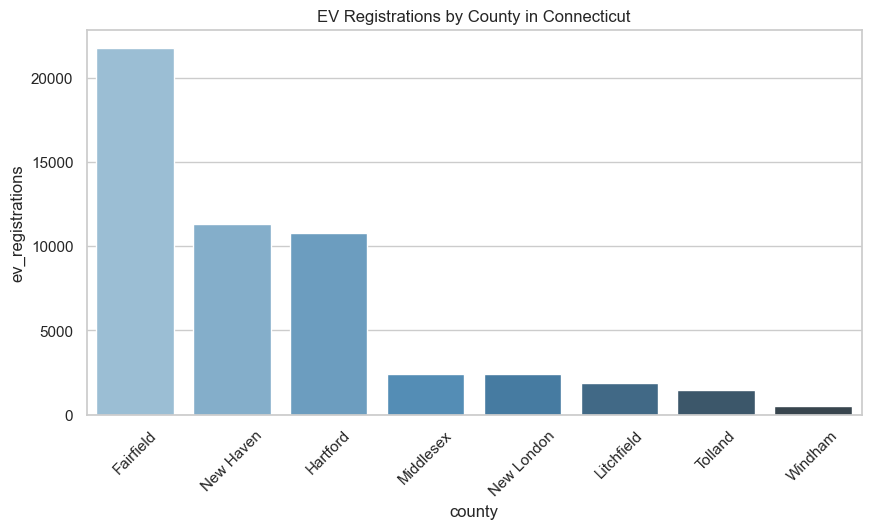

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(data=ev_count_by_county, x='county', y='ev_registrations', palette='Blues_d')
plt.xticks(rotation=45)
plt.title("EV Registrations by County in Connecticut")
plt.show()


Bar Chart: Charging Infrastructure by County

/var/folders/cv/lt0_qm2s5f11p3xt0drx0g4c0000gn/T/ipykernel_10709/3262689026.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ch_summary_by_county, x='county', y='total_chargers', palette='Greens_d')


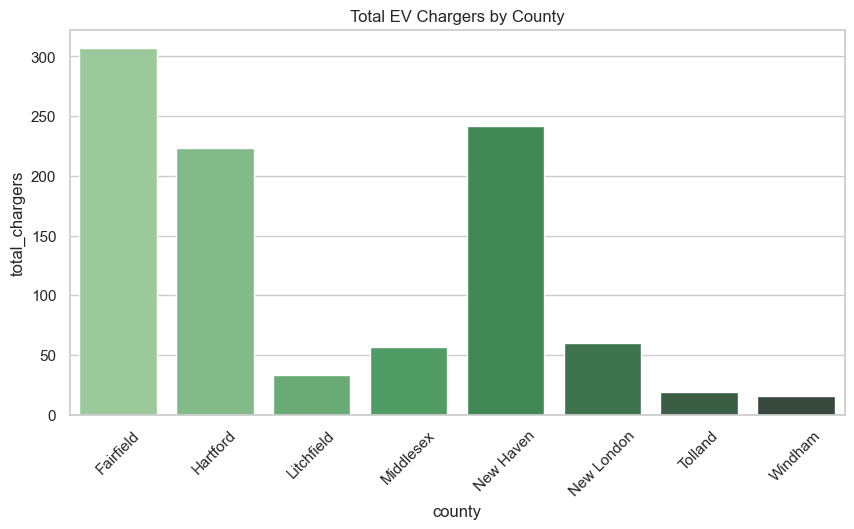

In [96]:
plt.figure(figsize=(10,5))
sns.barplot(data=ch_summary_by_county, x='county', y='total_chargers', palette='Greens_d')
plt.xticks(rotation=45)
plt.title("Total EV Chargers by County")
plt.show()


Scatter Plot: EV Adoption vs Income

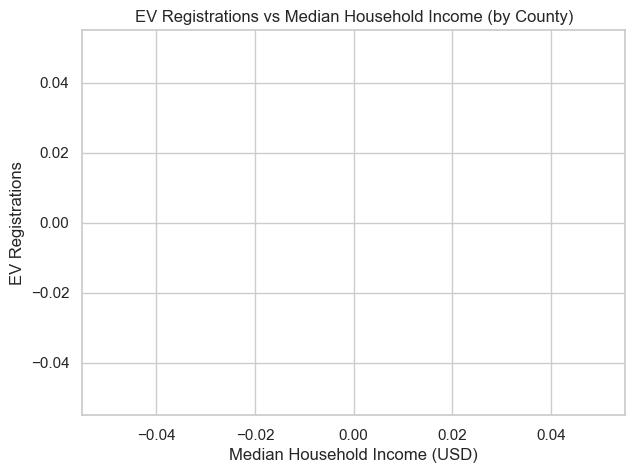

In [109]:
plot_data = county_full.dropna(subset=["median_income", "ev_registrations"])

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=plot_data,
    x="median_income",
    y="ev_registrations",
    s=120
)
plt.title("EV Registrations vs Median Household Income (by County)")
plt.xlabel("Median Household Income (USD)")
plt.ylabel("EV Registrations")
plt.show()


In [101]:
# Work only with the county rows (drop the state-level "Connecticut")
health_ct = health[health["county"] != "Connecticut"].copy()

# Make a clean county name without the word "County"
health_ct["county_clean"] = (
    health_ct["county"]
    .str.replace(" County", "", regex=False)  # "Windham County" -> "Windham"
    .str.strip()
    .str.title()                              # "WINDHAM"/**other** -> "Windham"
)

# Quick check
print(health_ct[["county", "county_clean", "median_income"]])


              county county_clean  median_income
2     Windham County      Windham          77748
3   New Haven County    New Haven          83971
4  New London County   New London          89428
5    Hartford County     Hartford          89982
6  Litchfield County   Litchfield          95323
7   Middlesex County    Middlesex          97859
8     Tolland County      Tolland         103443
9   Fairfield County    Fairfield         114462


In [103]:
print("county_full columns:")
print(county_full.columns.tolist())

print("\nhealth_ct columns:")
print(health_ct.columns.tolist())


county_full columns:
['county', 'ev_registrations', 'total_stations', 'total_chargers', 'fast_chargers', 'level2_chargers', 'level1_chargers', 'median_income']

health_ct columns:
['county', 'fips', 'median_income', 'us_rank', 'county_clean']


In [105]:
# Find the median-income column name in county_full
median_cols = [c for c in county_full.columns if "median" in c.lower()]

print("Median-related columns in county_full:", median_cols)

# Use the first one and rename it to 'median_income'
if median_cols:
    county_full = county_full.rename(columns={median_cols[0]: "median_income"})


Median-related columns in county_full: ['median_income']


In [1]:
%%writefile app.py
from pathlib import Path
import numpy as np
import pandas as pd
import streamlit as st
import altair as alt
import pydeck as pdk
import re

# ---------------------------------------------------------------
# Base directory: folder where app.py lives (OIM7502_F25)
# ---------------------------------------------------------------
BASE_DIR = Path(__file__).resolve().parent

# Convenience paths for all three raw files
HEALTH_PATH = BASE_DIR / "HDPulse_data_export.csv"
EV_REG_PATH = BASE_DIR / "Electric_Vehicle_Registration_Data.csv"
CHARGE_PATH = BASE_DIR / "Electric_Vehicle_Charging_Stations.csv"

# ---------------------------------------------------------------
# Streamlit page config
# ---------------------------------------------------------------
st.set_page_config(
    page_title="CT EV Infrastructure & Energy Capacity Explorer",
    layout="wide",
)

st.title("CT EV Infrastructure & Energy Capacity Explorer")
st.caption(
    "Interactive documentation of the cleaned EV registration, charging, "
    "and county-level income data stored in the OIM7502_F25 folder."
)

st.markdown(
    """
**Data location**

All source files and this app live in the same folder:

`OIM7502_F25/`  
- `HDPulse_data_export.csv`  
- `Electric_Vehicle_Registration_Data.csv`  
- `Electric_Vehicle_Charging_Stations.csv`  
- `Data cleaning.ipynb`  
- `app.py`
"""
)

# ---------------------------------------------------------------
# City → County mapping
# (⚠ Paste your full ct_city_to_county dict here; some examples only)
# ---------------------------------------------------------------
ct_city_to_county = {
    # Fairfield County (examples)
    "BETHEL": "Fairfield",
    "BRIDGEPORT": "Fairfield",
    "BROOKFIELD": "Fairfield",
    "DANBURY": "Fairfield",
    "DARIEN": "Fairfield",
    "FAIRFIELD": "Fairfield",
    "GREENWICH": "Fairfield",
    "NORWALK": "Fairfield",
    "RIDGEFIELD": "Fairfield",
    "STAMFORD": "Fairfield",
    "STRATFORD": "Fairfield",
    "TRUMBULL": "Fairfield",
    "WESTPORT": "Fairfield",
    "WILTON": "Fairfield",

    # Hartford County (examples)
    "AVON": "Hartford",
    "BRISTOL": "Hartford",
    "CANTON": "Hartford",
    "EAST HARTFORD": "Hartford",
    "GLASTONBURY": "Hartford",
    "HARTFORD": "Hartford",
    "MANCHESTER": "Hartford",
    "NEW BRITAIN": "Hartford",
    "NEWINGTON": "Hartford",
    "SIMSBURY": "Hartford",
    "WEST HARTFORD": "Hartford",
    "WETHERSFIELD": "Hartford",
    "WINDSOR": "Hartford",
    "WINDSOR LOCKS": "Hartford",

    # 👉 Add the rest of your mapping here (New Haven, New London, etc.)
}

# ---------------------------------------------------------------
# Data loading & cleaning – all paths go through BASE_DIR
# ---------------------------------------------------------------
@st.cache_data
def load_and_clean_data():
    # ----- Health / income data -----
    health_raw = pd.read_csv(
        HEALTH_PATH,
        skiprows=4,
        engine="python",
    )

    health_raw.columns = health_raw.columns.str.strip()
    health = health_raw.rename(
        columns={
            "County": "county",
            "FIPS": "fips",
            "Value (Dollars)": "median_income",
            "Rank within US (of 3141 counties)": "us_rank",
        }
    )

    # Drop US aggregate row, keep CT counties only
    health = health[health["county"] != "United States"].copy()

    health["median_income"] = (
        health["median_income"]
        .astype(str)
        .str.replace(",", "", regex=False)
    )
    health["median_income"] = pd.to_numeric(
        health["median_income"], errors="coerce"
    )
    health = health.dropna(subset=["median_income"]).copy()
    health["median_income"] = health["median_income"].astype(int)

    health["us_rank"] = (
        health["us_rank"]
        .astype(str)
        .str.extract(r"(\d+)", expand=False)
    )
    health["us_rank"] = pd.to_numeric(health["us_rank"], errors="coerce")
    health = health.dropna(subset=["us_rank"]).copy()
    health["us_rank"] = health["us_rank"].astype(int)

    health["county"] = (
        health["county"]
        .astype(str)
        .str.replace(" County", "", regex=False)
        .str.strip()
    )

    # ----- EV registration data -----
    ev_reg = pd.read_csv(
        EV_REG_PATH,
        low_memory=False,
    )

    ev_clean = ev_reg.copy()
    ev_clean.columns = ev_clean.columns.str.lower().str.replace(" ", "_")

    ev_clean["registration_start_date"] = pd.to_datetime(
        ev_clean["registration_start_date"], errors="coerce"
    )
    ev_clean["registration_expiration_date"] = pd.to_datetime(
        ev_clean["registration_expiration_date"], errors="coerce"
    )
    ev_clean["vehicle_year"] = pd.to_numeric(
        ev_clean["vehicle_year"], errors="coerce"
    )

    ev_clean["primary_customer_city"] = (
        ev_clean["primary_customer_city"].astype(str).str.strip().str.title()
    )
    ev_clean["vehicle_make"] = ev_clean["vehicle_make"].astype(str).str.title()
    ev_clean["vehicle_model"] = ev_clean["vehicle_model"].astype(str).str.title()
    ev_clean["vehicle_type"] = ev_clean["vehicle_type"].astype(str).str.upper()

    ev_clean = ev_clean[ev_clean["primary_customer_state"] == "CT"]
    ev_clean = ev_clean.drop_duplicates(subset=["id"])

    ev_clean["ev_count"] = 1
    ev_clean["ev_category"] = ev_clean["fuel_code"].replace(
        {"E00": "BEV", "H04": "PHEV"}
    ).fillna("Other")

    # ----- Charging station data -----
    ch_raw = pd.read_csv(CHARGE_PATH)

    ch = ch_raw.copy()
    ch.columns = (
        ch.columns.str.lower()
        .str.replace(" ", "_")
        .str.replace(r"[^a-z0-9_]", "", regex=True)
    )

    ch["city"] = ch["city"].astype(str).str.strip().str.title()

    for col in ["ev_level1_evse_num", "ev_level2_evse_num", "ev_dc_fast_count"]:
        ch[col] = pd.to_numeric(ch[col], errors="coerce").fillna(0).astype(int)

    ch["total_chargers"] = (
        ch["ev_level1_evse_num"]
        + ch["ev_level2_evse_num"]
        + ch["ev_dc_fast_count"]
    )
    ch["has_dc_fast"] = (ch["ev_dc_fast_count"] > 0).astype(int)
    ch["has_level2"] = (ch["ev_level2_evse_num"] > 0).astype(int)
    ch["has_level1"] = (ch["ev_level1_evse_num"] > 0).astype(int)

    ch["ev_other_info"] = (
        ch["ev_other_info"]
        .fillna("")
        .str.upper()
        .str.strip()
    )
    ch["is_tesla_connector"] = ch["ev_other_info"].str.contains("TESLA").astype(int)
    ch["is_conductive_120"] = ch["ev_other_info"].str.contains("120V").astype(int)
    ch["has_other_connector_info"] = (ch["ev_other_info"] != "NONE").astype(int)

    # ----- Map city → county -----
    ev_reg["city_clean"] = (
        ev_reg["Primary Customer City"].astype(str).str.upper().str.strip()
    )
    ch["city_clean"] = ch["city"].astype(str).str.upper().str.strip()

    ev_reg["county"] = ev_reg["city_clean"].map(ct_city_to_county)
    ch["county"] = ch["city_clean"].map(ct_city_to_county)

    # ----- County-level summaries -----
    ev_count_by_county = (
        ev_reg.groupby("county")
        .size()
        .reset_index(name="ev_registrations")
        .sort_values("ev_registrations", ascending=False)
    )

    ch_summary_by_county = (
        ch.groupby("county")
        .agg(
            total_stations=("station_name", "count"),
            total_chargers=("total_chargers", "sum"),
            fast_chargers=("has_dc_fast", "sum"),
            level2_chargers=("has_level2", "sum"),
            level1_chargers=("has_level1", "sum"),
        )
        .reset_index()
    )

    county_full = (
        ev_count_by_county
        .merge(ch_summary_by_county, on="county", how="outer")
        .merge(health[["county", "median_income"]], on="county", how="left")
    )

    county_full["evs_per_charger"] = (
        county_full["ev_registrations"]
        / county_full["total_chargers"].replace({0: np.nan})
    )

    # Lat/lon from georeferenced column
    if "new_georeferenced_column" in ch.columns:
        coords = ch["new_georeferenced_column"].astype(str).str.extract(
            r"POINT\s*\(([-\d\.]+)\s+([-\d\.]+)\)"
        )
        ch["lon"] = pd.to_numeric(coords[0], errors="coerce")
        ch["lat"] = pd.to_numeric(coords[1], errors="coerce")

    return ev_clean, ch, health, county_full


# ---------------------------------------------------------------
# Load data (all through BASE_DIR paths)
# ---------------------------------------------------------------
try:
    ev_clean, ch, health, county_full = load_and_clean_data()
except FileNotFoundError as e:
    st.error(
        "One of the required CSV files was not found.\n\n"
        "Make sure `HDPulse_data_export.csv`, "
        "`Electric_Vehicle_Registration_Data.csv`, and "
        "`Electric_Vehicle_Charging_Stations.csv` are in the SAME folder as app.py "
        "(OIM7502_F25).\n\n"
        f"Details: {e}"
    )
    st.stop()

# ---------------------------------------------------------------
# Sidebar filters
# ---------------------------------------------------------------
st.sidebar.header("Filters")

county_options = ["All"] + sorted(
    county_full["county"].dropna().unique().tolist()
)
selected_county = st.sidebar.selectbox("County", county_options, index=0)

ev_category_options = ["All"] + sorted(ev_clean["ev_category"].unique().tolist())
selected_ev_cat = st.sidebar.selectbox("EV Category", ev_category_options, index=0)

year_min, year_max = (
    int(ev_clean["vehicle_year"].min()),
    int(ev_clean["vehicle_year"].max()),
)
year_range = st.sidebar.slider(
    "Vehicle year range",
    min_value=year_min,
    max_value=year_max,
    value=(year_min, year_max),
)

# Apply filters
ev_filtered = ev_clean.copy()
if selected_ev_cat != "All":
    ev_filtered = ev_filtered[ev_filtered["ev_category"] == selected_ev_cat]

ev_filtered = ev_filtered[
    (ev_filtered["vehicle_year"] >= year_range[0])
    & (ev_filtered["vehicle_year"] <= year_range[1])
]

if selected_county != "All":
    ev_filtered["city_clean"] = (
        ev_filtered["primary_customer_city"].astype(str).str.upper().str.strip()
    )
    ev_filtered["county"] = ev_filtered["city_clean"].map(ct_city_to_county)
    ev_filtered = ev_filtered[ev_filtered["county"] == selected_county]
    ch_filtered = ch[ch["county"] == selected_county]
    county_filtered = county_full[county_full["county"] == selected_county]
else:
    ch_filtered = ch
    county_filtered = county_full

# ---------------------------------------------------------------
# Tabs
# ---------------------------------------------------------------
tab_overview, tab_county, tab_maps = st.tabs(
    ["📘 Data Overview", "📊 County Comparison", "🗺️ Maps"]
)

# ---------------------------------------------------------------
# TAB 1 – OVERVIEW
# ---------------------------------------------------------------
with tab_overview:
    st.subheader("Cleaned data summary")

    c1, c2, c3 = st.columns(3)
    c1.metric("EV records (CT)", f"{len(ev_clean):,}")
    c2.metric("Charging stations", f"{len(ch):,}")
    c3.metric("Counties with income data", f"{health['county'].nunique()}")

    st.markdown("#### Sample of cleaned EV registrations")
    st.dataframe(ev_filtered.head(50), use_container_width=True)

    st.markdown("#### Sample of cleaned charging stations")
    st.dataframe(ch_filtered.head(50), use_container_width=True)

    st.markdown("#### County-level summary (joined table)")
    st.dataframe(county_filtered, use_container_width=True)

# ---------------------------------------------------------------
# TAB 2 – COUNTY COMPARISON
# ---------------------------------------------------------------
with tab_county:
    st.subheader("EV adoption vs charging capacity by county")

    ev_bar = (
        alt.Chart(county_full)
        .mark_bar()
        .encode(
            x=alt.X("county:N", sort="-y", title="County"),
            y=alt.Y("ev_registrations:Q", title="EV registrations"),
            tooltip=[
                "county:N",
                "ev_registrations:Q",
                "total_chargers:Q",
                "evs_per_charger:Q",
                "median_income:Q",
            ],
        )
        .properties(height=350)
    )
    st.altair_chart(ev_bar, use_container_width=True)

    st.markdown("##### EVs per charger vs. median household income")
    scatter = (
        alt.Chart(
            county_full.dropna(subset=["evs_per_charger", "median_income"])
        )
        .mark_circle(size=150)
        .encode(
            x=alt.X("median_income:Q", title="Median household income (USD)"),
            y=alt.Y("evs_per_charger:Q", title="EVs per public charger"),
            color=alt.Color("county:N", legend=None),
            tooltip=[
                "county:N",
                "ev_registrations:Q",
                "total_chargers:Q",
                "evs_per_charger:Q",
                "median_income:Q",
            ],
        )
        .interactive()
    )
    st.altair_chart(scatter, use_container_width=True)

    st.markdown("##### Chargers vs. EV registrations")
    scatter2 = (
        alt.Chart(county_full)
        .mark_circle(size=150)
        .encode(
            x=alt.X("ev_registrations:Q", title="EV registrations"),
            y=alt.Y("total_chargers:Q", title="Total public chargers"),
            color=alt.Color("median_income:Q", title="Median income"),
            tooltip=[
                "county:N",
                "ev_registrations:Q",
                "total_chargers:Q",
                "fast_chargers:Q",
                "level2_chargers:Q",
                "median_income:Q",
            ],
        )
        .interactive()
    )
    st.altair_chart(scatter2, use_container_width=True)

# ---------------------------------------------------------------
# TAB 3 – MAPS
# ---------------------------------------------------------------
with tab_maps:
    st.subheader("Spatial distribution of public chargers in Connecticut")

    ch_map = ch_filtered.dropna(subset=["lat", "lon"]).copy()

    if ch_map.empty:
        st.warning("No stations with valid coordinates after filtering.")
    else:
        avg_lat = ch_map["lat"].mean()
        avg_lon = ch_map["lon"].mean()

        st.markdown(
            "Bubble size reflects total chargers per station; color reflects DC fast availability."
        )

        layer = pdk.Layer(
            "ScatterplotLayer",
            data=ch_map,
            get_position="[lon, lat]",
            get_radius="total_chargers * 400",
            get_fill_color=[
                "has_dc_fast * 255",
                "has_level2 * 180",
                120,
                180,
            ],
            pickable=True,
        )

        view_state = pdk.ViewState(
            longitude=avg_lon,
            latitude=avg_lat,
            zoom=7,
            pitch=35,
        )

        deck = pdk.Deck(
            layers=[layer],
            initial_view_state=view_state,
            tooltip={
                "text": "{station_name}\n{city}, {county}\n"
                        "Total chargers: {total_chargers}\n"
                        "DC fast: {ev_dc_fast_count}"
            },
        )

        st.pydeck_chart(deck)


Writing app.py
